### Машинное обучение
## Домашнее задание №3 - Градиентный бустинг

**Общая информация**

**Срок сдачи:** 14 мая 2024, 23:59   
**Штраф за опоздание:** -2 балла за каждые сутки

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте.

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге.

Ваше решение тут

$y_{n+1} = y_n - \lambda \frac{∂L(a(x_i), y_i)}{∂a(x_i)}$

1) $L(a(x_i), y_i) = (y_i - a(x_i))^2$

$\frac{∂L(a(x_i), y_i)}{∂a(x_i)} = \frac{∂(y_i-a(x_i))^2}{∂a(x_i)} = -2(y_i - a(x_i))$

2) $L(a(x_i), y_i) = e^{-a(x_i)y_i}$

$\frac{∂L(a(x_i), y_i)}{∂a(x_i)} = \frac{∂e^{-a(x_i)y_i}}{a(x_i)} = -y_ie^{-a(x_i)y_i}$

3) $L(a(x_i), y_i) = log(1+e^{-a(x_i)y_i}) = \frac{-y_ie^{-a(x_i)y_i}}{1+e^{-a(x_i)y_i}}$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn.


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [244]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression

In [239]:
a = np.array([1,2,3,-1,1,1,1,2,3,1,1,1,1,1])

pd.get_dummies(a).to_numpy()

array([[False,  True, False, False],
       [False, False,  True, False],
       [False, False, False,  True],
       [ True, False, False, False],
       [False,  True, False, False],
       [False,  True, False, False],
       [False,  True, False, False],
       [False, False,  True, False],
       [False, False, False,  True],
       [False,  True, False, False],
       [False,  True, False, False],
       [False,  True, False, False],
       [False,  True, False, False],
       [False,  True, False, False]])

In [3]:
from copy import copy, deepcopy

In [471]:
class MyGradientBoostingClassifier:

    def __init__(self, loss="EXP", learning_rate=1, n_estimators=10, colsample=1, subsample=1, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.kwargs = kwargs

    def _softmax(self, predictions):
        exp = np.exp(predictions)
        return exp / np.sum(exp, axis=1, keepdims=True)

    def _calc_grad(self, y, y_hat):
        if self.loss == "MSE":
            return (y - y_hat)
        if self.loss == "EXP":
            return y*np.exp(-y_hat*y)
        if self.loss == "LOG":
            return (y*np.exp(-y_hat*y))/(1+np.exp(-y_hat*y))

    def to_ohe_numbers(self, X):
        ohe_y = pd.get_dummies(X).to_numpy()
        ohe_y_mask = ohe_y == True
        res_y = np.zeros(ohe_y.shape)
        res_y[ohe_y_mask] = 1
        return res_y

    def fit(self, X, y, base_model=DecisionTreeRegressor(), init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        self.K = len(np.unique(y))
        self.models = {k: [] for k in range(self.K)}
        self.init_model = []

        self.object_indices = np.random.choice(X.shape[0], int((X.shape[0])*self.subsample), replace = False)
        self.feature_indices = np.random.choice(X.shape[1], int((X.shape[1])*self.colsample), replace = False)
        X = X[self.object_indices][:, self.feature_indices]
        y = y[self.object_indices]

        ohe_y = self.to_ohe_numbers(y)

        predictions = np.zeros(ohe_y.shape)
        probabilities = self._softmax(predictions)

        if init_model is not None:
            init_estimator = deepcopy(init_model)
            init_estimator.fit(X, y)
            pred = init_estimator.predict(X)
            self.init_model.append(init_estimator)
            predictions = self.to_ohe_numbers(pred)

        for i in range(self.n_estimators):
            probabilities = self._softmax(predictions)
            for k in range(self.K):
                ant_grad = self._calc_grad(ohe_y[:, k], probabilities[:, k])
                base_estimator = deepcopy(base_model)
                base_estimator = base_estimator.set_params(**self.kwargs)
                base_estimator.fit(X, ant_grad)
                self.models[k].append(base_estimator)
                predictions[:, k] += self.learning_rate*base_estimator.predict(X)


    def predict(self, X):
        if len(self.init_model) != 0:
            #print(X.shape, type(X))
            init_pred = self.init_model[0].predict(X[:, self.feature_indices])
            init_pred
            pred = self.to_ohe_numbers(init_pred)

        else:
            pred = np.zeros((X.shape[0], self.K))

        for i in range(self.n_estimators):
            for k in range(len(self.models)):
                #print(self.models[k][i].predict(X), self.models[k][i].predict(X).shape)
                pred[:, k] += self.learning_rate*self.models[k][i].predict(X[:, self.feature_indices])
        return np.argmax(pred, axis=1)


In [473]:
my_clf = MyGradientBoostingClassifier(max_depth=3)
clf = GradientBoostingClassifier()

In [474]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target, random_state = 42)

In [477]:
my_clf.fit(X_train, y_train, init_model = LogisticRegression())
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GradientBoostingClassifier()

In [478]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации.


In [483]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [484]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [485]:
y[y == 0] = -1
y

array([ 1,  1,  1, ..., -1, -1, -1])

In [487]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)

In [481]:
myclf = MyGradientBoostingClassifier(loss = "LOG")
myclf.fit(X_train, y_train)

In [482]:
y_pred = myclf.predict(X_val)
y_pred[y_pred == 0] = -1
y_pred

array([-1, -1,  1, ...,  1, -1, -1])

In [40]:
y_val

array([-1,  1, -1, ..., -1, -1,  1])

In [41]:
accuracy_score(y_val, y_pred)

0.8349483204134367

In [ ]:
accuracy_list = []
best_accuracy = 0
best_n_estimators = 0

for iterations in tqdm(range(1, 30)):
    myclf = MyGradientBoostingClassifier(loss = "MSE", n_estimators=iterations)
    myclf.fit(X_train, y_train)
    y_pred = myclf.predict(X_val)
    y_pred[y_pred == 0] = -1
    accuracy_list.append(accuracy_score(y_val, y_pred))
    if (best_accuracy<accuracy_list[-1]):
        best_accuracy = accuracy_list[-1]
        best_n_estimators = iterations

100%|██████████| 29/29 [02:13<00:00,  4.61s/it]


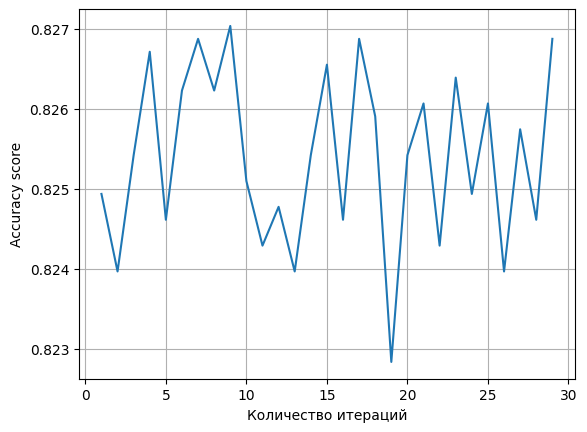

In [ ]:
plt.plot(range(1,30), accuracy_list)
plt.xlabel("Количество итераций")
plt.ylabel("Accuracy score")
plt.grid()

In [ ]:
accuracy_list = []
best_accuracy = 0
best_params = {"max_depth":0, "loss":0, "min_samples_split":0}

for loss in tqdm(['MSE','EXP','LOG']):
    for max_depth in range(3, 5):
        for min_samples_split in range(3, 7):
            myclf = MyGradientBoostingClassifier(loss = loss, n_estimators=best_n_estimators, max_depth = max_depth, min_samples_split = min_samples_split)
            myclf.fit(X_train, y_train)
            y_pred = myclf.predict(X_val)
            y_pred[y_pred == 0] = -1
            accuracy_list.append(accuracy_score(y_val, y_pred))
            if (best_accuracy<accuracy_list[-1]):
                best_accuracy = accuracy_list[-1]
                best_params["max_depth"] = max_depth
                best_params["loss"] = loss
                best_params["min_samples_split"] = min_samples_split

100%|██████████| 3/3 [00:21<00:00,  7.13s/it]


In [ ]:
best_params

{'max_depth': 4, 'loss': 'MSE', 'min_samples_split': 3}

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

**Boosting on RandomForest**

In [31]:
from sklearn.ensemble import RandomForestRegressor

In [42]:
boobag = MyGradientBoostingClassifier(max_depth=5)
boobag.fit(X_train, y_train, base_model = RandomForestRegressor())

In [43]:
y_train

array([ 1, -1, -1, ..., -1,  1, -1])

In [44]:
y_val

array([-1,  1, -1, ..., -1, -1,  1])

In [45]:
y_pred_boobag = boobag.predict(X_val)
y_pred_boobag[y_pred_boobag == 0] = -1
y_pred_boobag

array([-1,  1,  1, ..., -1, -1, -1])

In [46]:
accuracy_score(y_val, y_pred_boobag)

0.8536821705426356

Обычные деревья более слабые чем случайные леса, потому что у дерева высокий varience, а у ансабля от поменьше(за счет тоо, что их много и результат усредняется), что повышает генерализирующее свойство всей модели. Получается, что базовая модель сильнее => антиградиент лучше предсказывается => лучше скор бустинга

**Ensemble on Boostings**

In [162]:
y_pred_list = []

for boostings_idx in range(10):
    boosting = MyGradientBoostingClassifier(max_depth=3, subsample = 0.3)
    boosting.fit(X_train, y_train)
    y_pred_list.append(boosting.predict(X_val))

y_pred_list = np.array(y_pred_list)

In [163]:
y_pred_list.T

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [164]:
def Ensemble(x):
    vals, counts = np.unique(x, return_counts=True)
    return vals[np.argmax(counts)]

In [165]:
y_pred_bagboo = np.array(list(map(Ensemble, y_pred_list.T)))
y_pred_bagboo[y_pred_bagboo == 0] = -1

In [166]:
accuracy_score(y_val, y_pred_bagboo)

0.8357558139534884

Опять же ансамбль из бустингов обученных на бутстрапированной выборке показал результаты лучше чем бустинг на деревьях, потому бустинги имеют маленький bias, но обладают высоким varience, который снижается за счет ансамблирования (голосования за наиболее частый класс)

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [468]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [469]:
df = pd.DataFrame(index = ["LogReg", "RFC", "SVM"], columns = ["Accuracy"])

In [490]:
models = [LogisticRegression(), RandomForestClassifier(max_depth=5, random_state=0), SVC(gamma='auto')]
names = ["LogReg", "RFC", "SVM"]

for i in range(len(models)):
    clf_with_init_model = MyGradientBoostingClassifier()
    clf_with_init_model.fit(X_train, y_train, init_model = models[i])
    y_pred = clf_with_init_model.predict(X_val)
    y_pred[y_pred == 0] = -1
    df.loc[names[i]] = accuracy_score(y_val, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [491]:
df

,Accuracy
LogReg,0.849322
RFC,0.853844
SVM,0.837532


По результатам получилось, что качество с начальной моделью RandomForestClassifier, лучше всех оставшихся моделей. Однако начальная модель LogisticRegression, тоже побила скор начальной модели без ниициализации на обычных DecisionTreeRegressor()

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

Наиболее непонятно было, как сделать многоклассовую классификацию, потом пришлось прочитать статей и осознание пришло само собой. Но как мне кажется, лучше об этом рассказать на лекции или хотя бы где-то упомянуть в тетрадке.

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

Оч круто, жаль людей мало)

### ВАШ ОТЗЫВ ЗДЕСЬ

